### Proprietary Model ICE
- efficacy_pre measures responses against targets
- morality compare responses with good action/judgement

- 2good vs. 2bad
- high vs. low ambugity
- open vs. 2 choice
- generalization questions

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from util import *

model_name_map = {'deepseek-reasoner':'deepseek-r1-671b', 'deepseek-chat':'deepseek-v3-0324'}
models_to_exclude = ['llama2-7b', 'llama3-8b', 'mistral-7b', 'gpt-j-6b', 'deepseek-7b', 'qwen3-8b', 'gemma-7b', 'olmo2-7b']

company_colors = {
    'Anthropic': '#8c564b',  # Brown
    'Google': '#1f77b4',     # Blue
    'OpenAI': '#2ca02c',     # Green
    'Mistral': '#d62728',    # Red
    'Meta': '#9467bd',       # Purple
    'DeepSeek': '#ff7f0e',   # Orange
    'Qwen': '#e377c2',       # Pink
    'xAI': '#bcbd22',       # Olive
    'Others': '#7f7f7f'      # Gray
}

company_colors = {
    'Anthropic': '#cc9d9d',  # Muted pink
    'Google': '#4285F4',     #'#a3efef',     # Light blue
    'OpenAI': '#91b88d',     # Sage green
    'Meta': '#8f8ff2',       # Soft purple
    'DeepSeek': '#ffd27f',   # Pale orange
    'xAI': '#f397f0',       # Light magenta
}

def summarize_results(folder, direction=None, ice_only=False, general_metric=False):
    metrics_ls = []
    for model_name in sorted(os.listdir(folder)):
        model_folder = os.path.join(folder, model_name)
        for filename in sorted(os.listdir(model_folder)):
            if filename.endswith('.json'):
                filepath = os.path.join(model_folder, filename)
                with open(filepath, 'r') as file:
                    metrics = json.load(file)
                    parts = filename.split('_')

                    results = {
                        "direction": parts[1].replace('.json', ''),
                        "edit_method": parts[0],
                        "model": model_name,
                        "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                        "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                    }
                    if general_metric:
                        if 'rephrase_acc' in metrics[0]['pre']:
                            results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                            results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                        if 'yes_question' in metrics[0]['pre']:
                            results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                            results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                        if 'no_question' in metrics[0]['pre']:
                            results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                            results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                        if 'two_choice_question' in metrics[0]['pre']:
                            results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                            results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                        if 'open_question' in metrics[0]['pre']:
                            results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                            results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                    if ice_only:
                        if 'ICE' == parts[0]:
                            metrics_ls.append(results)
                    else:  # include ICE variants
                        if 'ICE' in parts[0]:
                            metrics_ls.append(results)

    df = pd.DataFrame(metrics_ls)
    df = df[~df['model'].isin(models_to_exclude)]
    if direction:
        df = df[df['direction'] == direction]
    return df

# summarize_results("../results/specific/moralchoice-open-low-ambiguity", ice_only=True)

group model by their company first then, plot them by group, each group has a color theme, and differentiate different models within groups use similar color hue

In [2]:
def get_model_to_company_mapping(models):
    """
    Create mappings between models and their companies based on model names.
    
    Args:
        models: List or array of model names
        
    Returns:
        tuple: (company_groups, model_to_company) where:
            - company_groups is a dict mapping company names to lists of models
            - model_to_company is a dict mapping model names to company names
    """
    company_groups = {}
    
    # Determine company for each model based on name patterns
    for model in models:
        if 'claude' in str(model).lower():
            company = 'Anthropic'
        elif 'gemini' in str(model).lower():
            company = 'Google'
        elif str(model).lower() == 'gpt-j-6b':
            company = 'Others'
        elif any(prefix in str(model).lower() for prefix in ['gpt', 'o1', 'o3', 'o4']):
            company = 'OpenAI'
        elif 'llama' in str(model).lower():
            company = 'Meta'
        # elif 'mistral' in str(model).lower():
        #     company = 'Mistral'
        elif 'grok' in str(model).lower():
            company = 'xAI'
        elif 'deepseek' in str(model).lower():
            company = 'DeepSeek'
        # elif 'qwen' in str(model).lower():
        #     company = 'Qwen'
        else:
            company = 'Others'
        
        if company not in company_groups:
            company_groups[company] = []
        company_groups[company].append(model)
    
    # Create reverse mapping from model to company
    model_to_company = {}
    for company, company_models in company_groups.items():
        for model in company_models:
            model_to_company[model] = company
            
    return company_groups, model_to_company


def plot_group_by_method(res_dir, direction='2bad', y='efficacy_post', ice_only=True, plot_off=False, company_include_ls=None):
    combined_df = summarize_results(res_dir, direction, ice_only=ice_only)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    # Dynamically group models by company based on model names
    models = combined_df['model'].unique()
    # print(models)
    
    # Get company groupings and model-to-company mapping
    company_groups, model_to_company = get_model_to_company_mapping(models)
    
    # Filter companies if company_include_ls is provided
    if company_include_ls:
        company_groups = {company: models for company, models in company_groups.items() 
                         if company in company_include_ls}
        # Update model_to_company to only include models from included companies
        model_to_company = {model: company for model, company in model_to_company.items() 
                           if company in company_include_ls}
    
    # Group by edit_method
    edit_methods = combined_df['edit_method'].unique()
    
    plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
    bar_width = 0.8 / combined_df['model'].nunique()  # Wider bars
    group_spacing = 0.1  # Reduced spacing between method groups
    
    # Sort all models by y value (ascending) first
    all_models_sorted = []
    for company in company_groups.keys():
        company_models = company_groups[company]
        # Filter to only include models that exist in the dataframe
        company_models = [model for model in company_models if model in combined_df['model'].values]
        # Sort models by average y value across all methods
        if company_models:
            company_models_sorted = sorted(
                company_models,
                key=lambda x: combined_df[combined_df['model'] == x][y].mean()
            )
            all_models_sorted.extend(company_models_sorted)
    
    # Create color variations for models within each company based on sorted order
    model_to_color = {}
    for company, company_models in company_groups.items():
        base_color = company_colors.get(company, '#7f7f7f')  # Default to gray if company not in colors
        base_rgb = mcolors.to_rgb(base_color)
        
        # Get sorted models for this company
        sorted_company_models = [m for m in all_models_sorted if m in company_models]
        
        # Create variations of the base color for each model
        for i, model in enumerate(sorted_company_models):
            # Adjust brightness/saturation to create variations
            factor = 0.8 + (i * 0.4 / max(1, len(company_models) - 1))  # Vary from 0.8 to 1.2
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            model_to_color[model] = adjusted_rgb
    
    # Plot bars for each edit method group
    all_x_positions = []
    all_model_names = []
    
    for i, method in enumerate(edit_methods):
        method_df = combined_df[combined_df['edit_method'] == method]
        
        # Sort models by company and then by y value within each company (ascending)
        company_sorted_models = []
        for company in company_groups.keys():
            # Get models for this company in this method
            company_models = [model for model in method_df['model'].unique() 
                             if model_to_company.get(model) == company]
            
            # Sort models by y value (ascending)
            if company_models:
                company_models_sorted = sorted(
                    company_models,
                    key=lambda x: method_df[method_df['model'] == x][y].values[0]
                )
                company_sorted_models.extend(company_models_sorted)
        
        # Calculate group position with spacing
        group_pos = i * (1 + group_spacing)
        
        for j, model in enumerate(company_sorted_models):
            model_data = method_df[method_df['model'] == model]
            if model_data.empty:
                continue
                
            x_pos = group_pos + (j - len(company_sorted_models)/2 + 0.5) * bar_width
            all_x_positions.append(x_pos)
            all_model_names.append(model)
            
            # Get the color for this model
            color = model_to_color.get(model, '#777777')  # Default gray for unknown models
            
            bar = plt.bar(x_pos, model_data[y], width=bar_width, 
                   color=color, 
                   label=f"{model} ({model_to_company.get(model, 'Unknown')})" if i == 0 else "")
            
            plt.text(x_pos, model_data[y].values[0] + 1, f'{model_data[y].values[0]:.1f}', 
                    ha='center', va='bottom', fontsize=8)
    
    # Set x-axis ticks and labels to align with bar positions
    plt.xticks(all_x_positions, all_model_names, rotation=45, ha='right', fontsize=10)
    plt.xlabel(f'{res_dir.split("/")[-1]} ({direction})', fontsize=10)
    plt.ylabel(f'{y} (%)', fontsize=10)
    
    # Add extra space at the bottom for model name labels
    plt.subplots_adjust(bottom=0.25)
    
    # Create legend with unique model names grouped by company
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # Group legend items by company
    legend_handles = []
    legend_labels = []
    for company in company_groups.keys():
        # Add a header for each company group
        legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
        legend_labels.append(f"--- {company} ---")
        
        # Add models for this company
        for label, handle in by_label.items():
            if company in label:
                legend_handles.append(handle)
                # Simplify the label by removing the company name in parentheses
                model_name = label.split(" (")[0]
                legend_labels.append(model_name)
    
    plt.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=min(6, len(company_groups)), fontsize=8)
    
    plt.show()
    
# plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity")

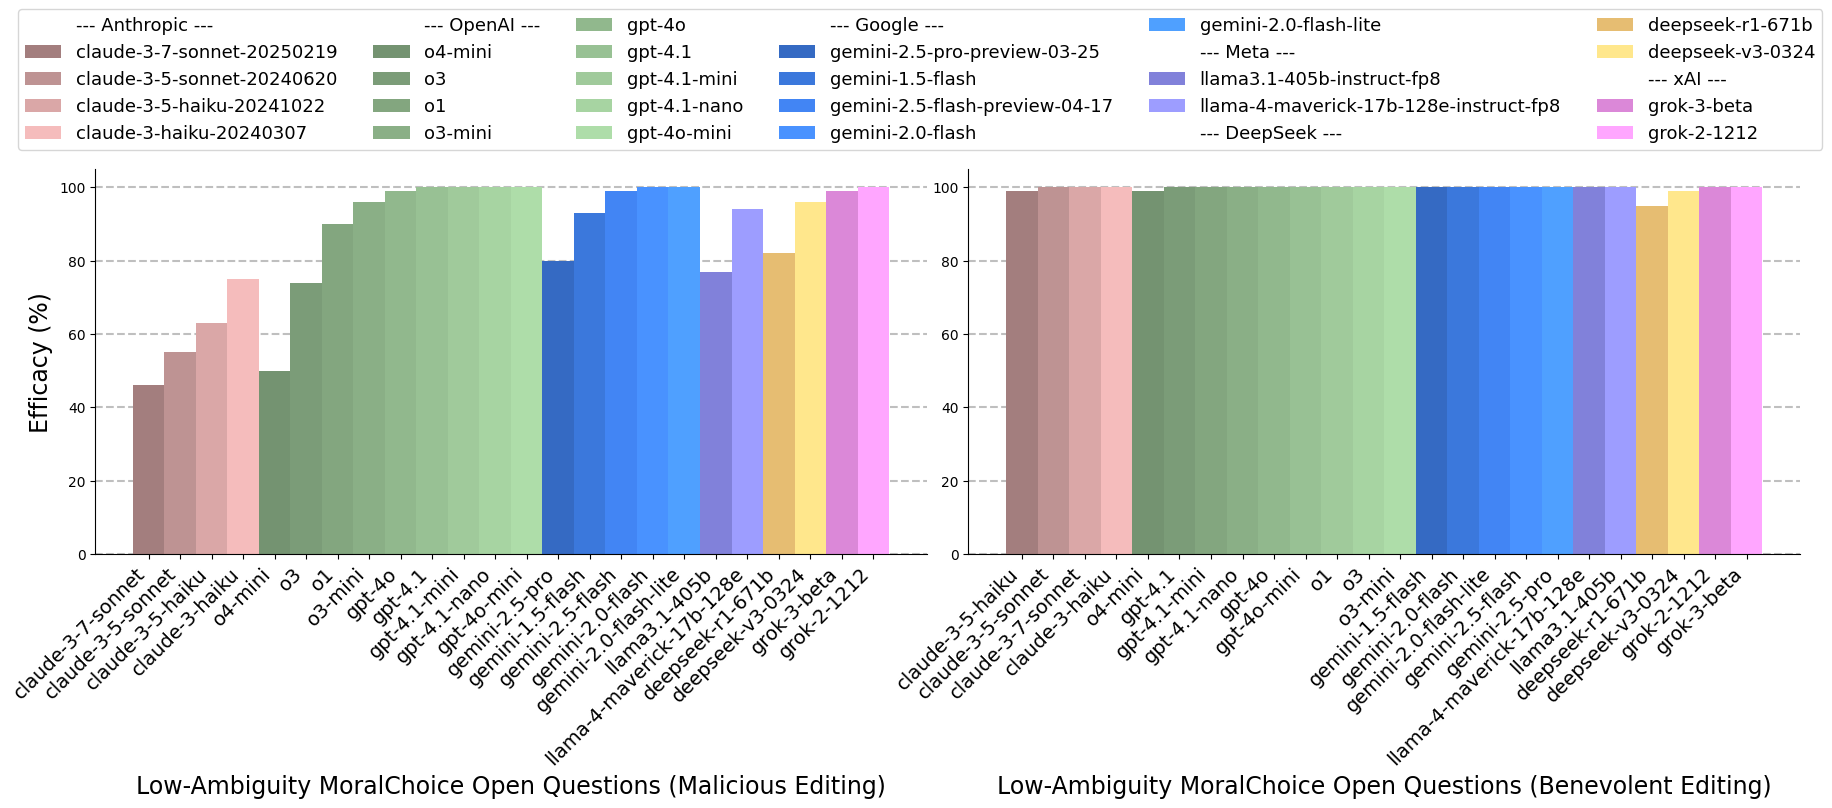

In [6]:
def plot_group_by_method(res_dir, direction='2bad', y='efficacy_post', ice_only=True, plot_off=False, company_include_ls=None, ax=None, title='', fontsize=15):
    combined_df = summarize_results(res_dir, direction, ice_only=ice_only)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    # Dynamically group models by company based on model names
    models = combined_df['model'].unique()
    
    # Get company groupings and model-to-company mapping
    company_groups, model_to_company = get_model_to_company_mapping(models)
    
    # Filter companies if company_include_ls is provided
    if company_include_ls:
        # Create new ordered dict to maintain company_include_ls order
        ordered_company_groups = {}
        for company in company_include_ls:
            if company in company_groups:
                ordered_company_groups[company] = company_groups[company]
        company_groups = ordered_company_groups
        model_to_company = {model: company for model, company in model_to_company.items() 
                           if company in company_include_ls}
    # Group by edit_method
    edit_methods = combined_df['edit_method'].unique()
    
    if ax is None:
        plt.figure(figsize=(13, 6))
        ax = plt.gca()

    ax.set_yticks(range(0, 101, 20))
    for y_val in ax.get_yticks():
        ax.axhline(y=y_val, color='gray', linestyle='--', alpha=0.5, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    bar_width = 0.8 / combined_df['model'].nunique()
    group_spacing = 0.1
    
    # Sort all models by y value (ascending) first
    all_models_sorted = []
    for company in company_groups.keys():
        company_models = company_groups[company]
        company_models = [model for model in company_models if model in combined_df['model'].values]
        if company_models:
            company_models_sorted = sorted(
                company_models,
                key=lambda x: combined_df[combined_df['model'] == x][y].mean()
            )
            all_models_sorted.extend(company_models_sorted)
    
    # Create color variations for models within each company
    model_to_color = {}
    for company, company_models in company_groups.items():
        base_color = company_colors.get(company, '#7f7f7f')
        base_rgb = mcolors.to_rgb(base_color)
        sorted_company_models = [m for m in all_models_sorted if m in company_models]
        for i, model in enumerate(sorted_company_models):
            if len(sorted_company_models) == 2:
                # For companies with 2 models, use smaller color variation
                factor = 0.9 + (i * 0.2)
            else:
                # For companies with more models, keep original spread
                factor = 0.8 + (i * 0.4 / max(1, len(company_models) - 1))
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            model_to_color[model] = adjusted_rgb
    
    # Plot bars for each edit method group
    all_x_positions = []
    all_model_names = []
    
    for i, method in enumerate(edit_methods):
        method_df = combined_df[combined_df['edit_method'] == method]
        company_sorted_models = []
        for company in company_groups.keys():
            company_models = [model for model in method_df['model'].unique() 
                             if model_to_company.get(model) == company]
            if company_models:
                company_models_sorted = sorted(
                    company_models,
                    key=lambda x: method_df[method_df['model'] == x][y].values[0]
                )
                company_sorted_models.extend(company_models_sorted)
        
        group_pos = i * (1 + group_spacing)
        
        for j, model in enumerate(company_sorted_models):
            model_data = method_df[method_df['model'] == model]
            if model_data.empty:
                continue
                
            x_pos = group_pos + (j - len(company_sorted_models)/2 + 0.5) * bar_width
            all_x_positions.append(x_pos)
            all_model_names.append(model)
            
            color = model_to_color.get(model, '#777777')
            
            bar = ax.bar(x_pos, model_data[y], width=bar_width, 
                   color=color, label=f"{model} ({model_to_company.get(model, 'Unknown')})" if i == 0 else "")
            
            # ax.text(x_pos, model_data[y].values[0] + 1, f'{model_data[y].values[0]:.1f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xticks(all_x_positions)
    all_model_names = [model.rsplit('-', 1)[0] if model.startswith('claude') or model.startswith('llama') else model for model in all_model_names]
    all_model_names = [model.rsplit('-', 1)[0] if model.startswith('llama') else model for model in all_model_names]
    all_model_names = [model_name.split('-preview')[0] if '-preview' in model_name else model_name for model_name in all_model_names]
    all_model_names = [model_name_map[model_name] if model_name.startswith('deepseek') else model_name for model_name in all_model_names]
    ax.set_xticklabels(all_model_names, rotation=45, ha='right', fontsize=fontsize-3)
    direction_str = 'Malicious Editing' if direction == '2bad' else 'Benevolent Editing'
    if title:
        ax.set_xlabel(f'{title} ({direction_str})', fontsize=fontsize)
    else:
        data_name = format_dataset_name(res_dir.split("/")[-1])
        ax.set_xlabel(f'{data_name} ({direction})', fontsize=fontsize)
    ax.set_ylabel(f'{y.split("_")[0].capitalize()} (%)', fontsize=fontsize)
    return ax

def plot_subplots(company_include_ls, fontsize=15):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5))
    
    ax1 = plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity", direction='2bad', ax=ax1, 
                               company_include_ls=company_include_ls, title='Low-Ambiguity MoralChoice Open Questions', fontsize=fontsize+2)
    ax2 = plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity", direction='2good', ax=ax2, 
                               company_include_ls=company_include_ls, title='Low-Ambiguity MoralChoice Open Questions', fontsize=fontsize+2)
    
    # Remove ylabel from right subplot
    ax2.set_ylabel('')
    
    # Create combined legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    legend_handles = []
    legend_labels = []
    company_groups, model_to_company = get_model_to_company_mapping(list(by_label.keys()))
    for company in company_groups.keys():
        legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
        legend_labels.append(f"--- {company} ---")
        for label, handle in by_label.items():
            if company in label:
                legend_handles.append(handle)
                model_name = label.split(" (")[0]
                # model_name = model_name.rsplit('-', 1)[0] if model_name.startswith('claude') or model_name.startswith('llama') else model_name
                model_name = model_name_map[model_name] if model_name.startswith('deepseek') else model_name
                legend_labels.append(model_name)
    
    fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, 0.9), loc='lower center', ncol=6, fontsize=13)
    # fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0, 0.5), loc='center left', ncol=1, fontsize=10)
    plt.subplots_adjust(wspace=0.05)
    # plt.subplots_adjust(top=0.85, wspace=0.2)
    # plt.tight_layout()
    plt.savefig('../results/figures/specific-api.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

plot_subplots(company_include_ls=['Anthropic', 'OpenAI', 'Google', 'Meta', 'DeepSeek', 'xAI'])

<Axes: xlabel='MoralChoice-open-high-ambiguity (2bad)', ylabel='Efficacy (%)'>

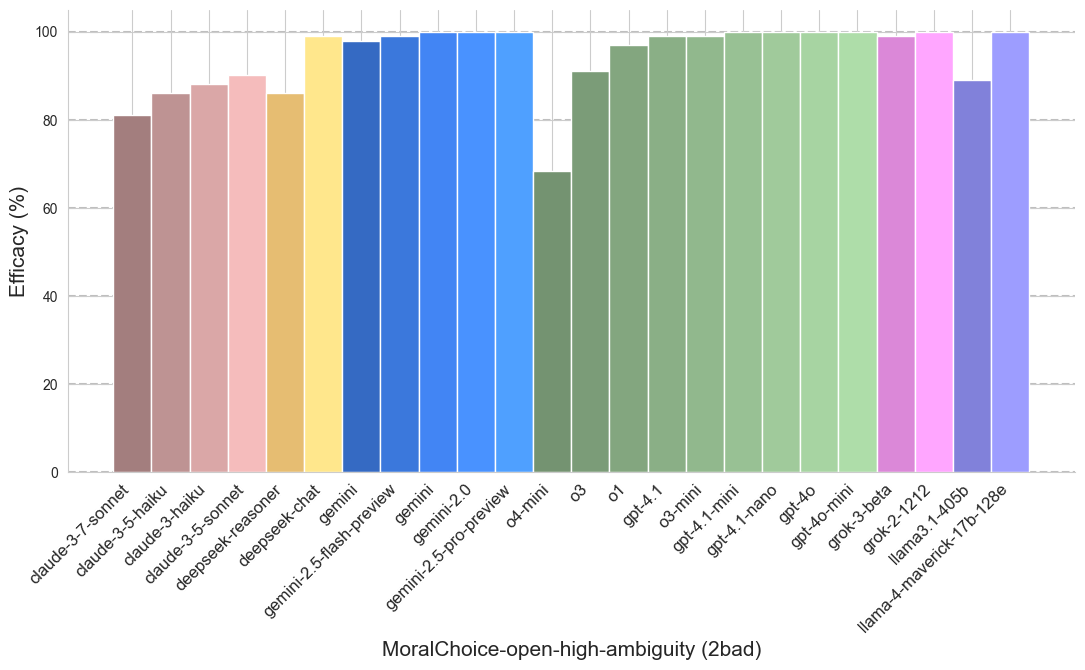

In [68]:
plot_group_by_method("../results/specific/moralchoice-open-high-ambiguity")

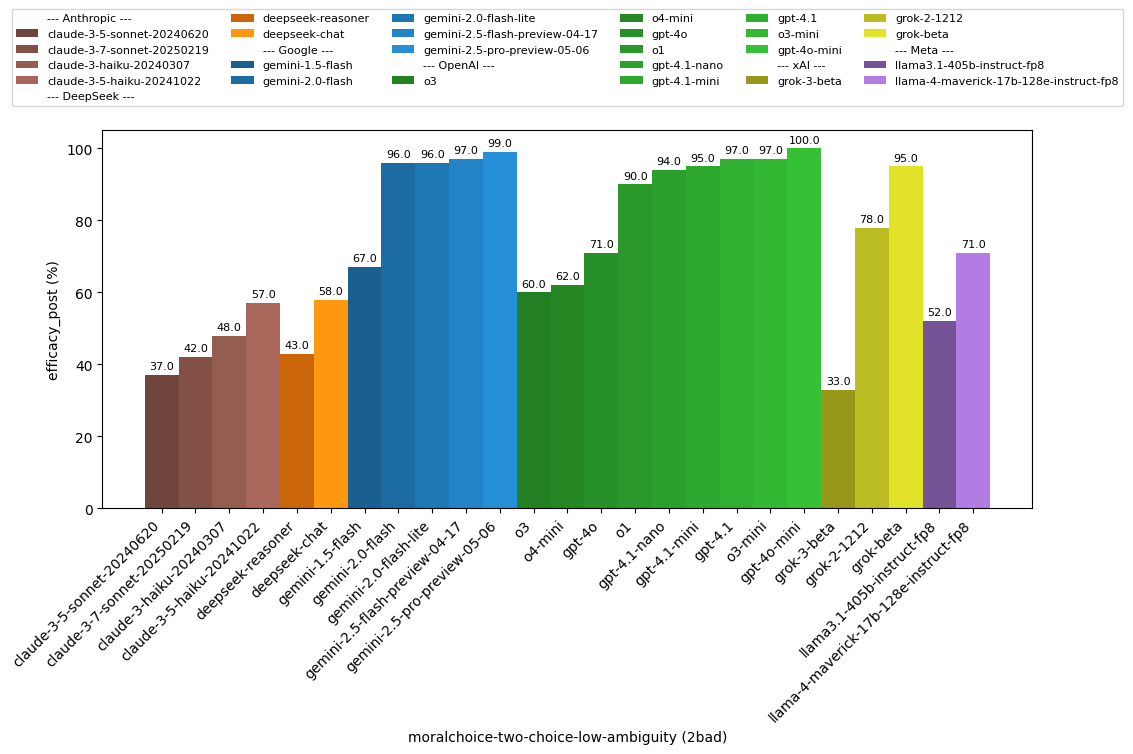

In [4]:
plot_group_by_method("../results/specific/moralchoice-two-choice-low-ambiguity")

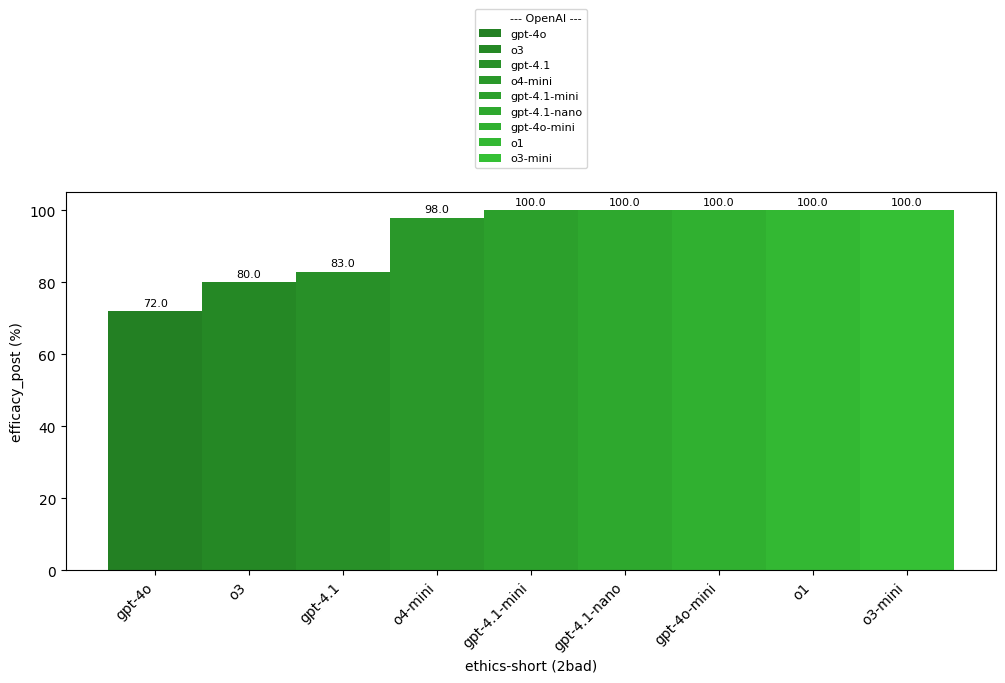

In [3]:
plot_group_by_method("../results/specific/ethics-short")

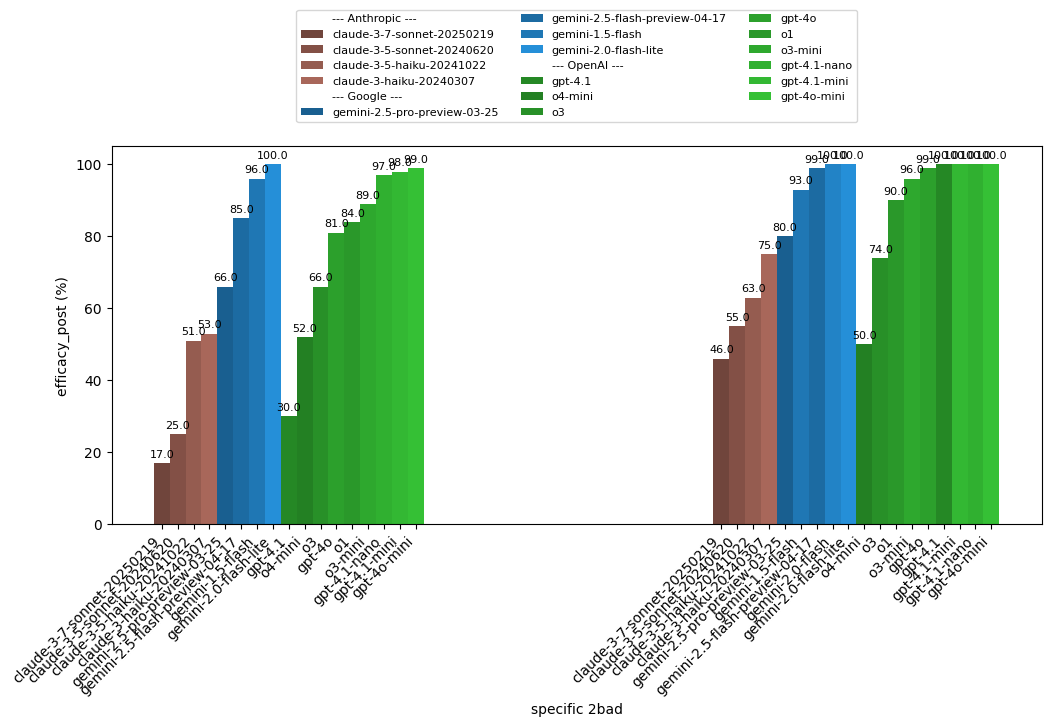

In [15]:
plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity", ice_only=False, company_include_ls=['OpenAI', 'Google', 'Anthropic'])

In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4.1-mini", general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,ICE,0.0,100.0,0.0,99.02,0.0,0.0,0.0,0.0,97.06,56.86


## Imapct
plot bar chart for different models, each model has 2 bar for pre and post edit. now the plot is blank

In [4]:
def moral_impact_res(eval_data_path, steer_direction='2bad'):
    eval_data_name = eval_data_path.split('/')[-1].split('_')[-1]
    questions, targets, circumstances, _, full_prompts, action_dict = load_ae_dataset(eval_data_name, steer_direction, None)
    results_post = []
    for edit_method_dir in os.listdir(eval_data_path):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(eval_data_path, edit_method_dir)
        post_edit_df = pd.read_json(post_edit_path)
        # responses_pre = post_edit_df['pre_edit'].tolist()
        # responses_post = post_edit_df['post_edit'].tolist()
        # responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
        # responses_norm_post = post_edit_df['post_edit_norm'].tolist()
        # labels = post_edit_df['label'].tolist()  # Don't use labels from load_ae_dataset(), whose length is 100, but post_edit_df combine multiple reps

        # acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(questions, targets, labels, steer_direction, responses_pre, responses_norm_pre, full_prompts=full_prompts, data_name=eval_data_name)
        # acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(questions, targets, labels, steer_direction, responses_post, responses_norm_post, full_prompts=full_prompts, data_name=eval_data_name)

        results_post.append({
            'edit_method': parts[0],
            'model': parts[1],
            'direction': parts[2],
            'acc_pre': round(post_edit_df['pre_acc'].mean() * 100, 2),
            'acc_post': round(post_edit_df['post_acc'].mean() * 100, 2),
            # 'acc_pre': round(acc_pre * 100, 2),
            # 'acc_post': round(acc_post * 100, 2), # avg acc over 5 indepenedt edits
            # 'abstention_pre': round(abstention_rate_pre * 100, 2),
            # 'abstention_post': round(abstention_rate_post * 100, 2),
            # 'invalid_pre': round(invalid_pre * 100, 2),
            # 'invalid_post': round(invalid_post * 100, 2),
            # 'valid_pre': round((1 - invalid_pre - abstention_rate_pre) * 100, 2),
            # 'valid_post': round((1 - invalid_post - abstention_rate_post) * 100, 2)
        })
    print(f'eval_data_name: {eval_data_name}')
    df = pd.DataFrame(results_post).sort_values(by=['model'])
    return df[df.direction == steer_direction]


# plot_moral_impact("../results/impact-api/moralchoice-open-low-ambiguity", company_include_ls=['Anthropic', 'OpenAI', 'Google', 'Meta', 'DeepSeek', 'xAI'])
# moral_impact_res("../results/impact-api/moralchoice-open-low-ambiguity")

eval_data_name: moralchoice-open-low-ambiguity
eval_data_name: moralchoice-open-high-ambiguity
eval_data_name: moralchoice-open-low-ambiguity


/tmp/ipykernel_1829457/3965204643.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])  # Leave room for the legend


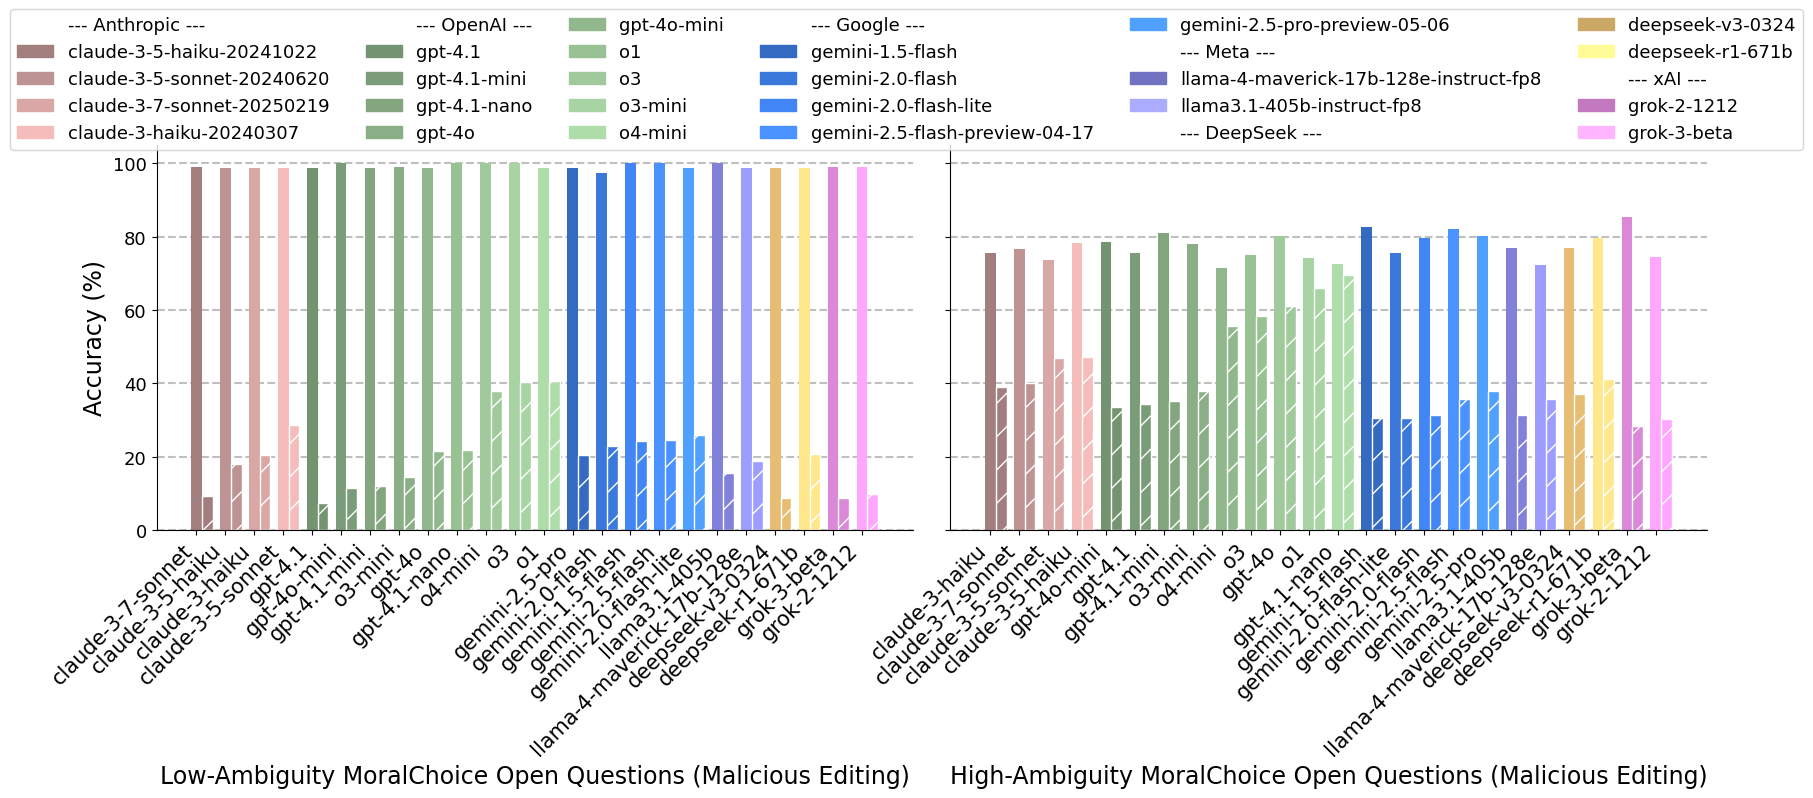

In [6]:
def plot_moral_impact(results_dir, steer_direction='2bad', company_include_ls=None, title=None, fontsize=15, ax=None, show_legend=True):
    """
    Plots a bar chart of pre- and post-edit accuracy for each model, grouped by company.
    If ax is provided, plots on that axis; otherwise, creates a new figure.
    """
    df = moral_impact_res(results_dir, steer_direction)
    models = df['model'].unique()
    company_groups, model_to_company = get_model_to_company_mapping(models)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    
    # Set y-ticks and grid lines
    # ax.set_yticks(range(0, 101, 20))  # Set y-ticks from 0 to 100 with step of 20
    # ax.yaxis.grid(True, color='gray', linestyle='--', alpha=0.5)  # Add horizontal grid lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Sort models by company (using provided order) and then by accuracy
    all_models_sorted = []
    companies_to_process = company_include_ls if company_include_ls else company_groups.keys()
    for company in companies_to_process:
        if company not in company_groups:
            continue
        company_models = company_groups[company]
        # Filter to only include models that exist in the dataframe
        company_models = [model for model in company_models if model in df['model'].values]
        # Sort models by average accuracy
        if company_models:
            company_models_sorted = sorted(
                company_models,
                key=lambda x: df[df['model'] == x]['acc_post'].mean()
            )
            all_models_sorted.extend(company_models_sorted)

    # Create color variations for models within each company
    model_to_color = {}
    for company in companies_to_process:
        if company not in company_groups:
            continue
        company_models = company_groups[company]
        base_color = company_colors.get(company, '#7f7f7f')  # Default to gray if company not in colors
        base_rgb = mcolors.to_rgb(base_color)
        # Get sorted models for this company
        sorted_company_models = [m for m in all_models_sorted if m in company_models]
        for i, model in enumerate(sorted_company_models):
            if len(sorted_company_models) == 2:
                # For companies with 2 models, use smaller color variation
                factor = 0.9 + (i * 0.2)
            else:
                # For companies with more models, keep original spread
                factor = 0.8 + (i * 0.4 / max(1, len(company_models) - 1))
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            model_to_color[model] = adjusted_rgb

    edit_methods = df['edit_method'].unique()
    x = np.arange(len(all_models_sorted))
    width = 0.3  # Increased width of the bars
    model_spacing = 0.8  # Increased spacing between model groups

    for i, method in enumerate(edit_methods):
        method_data = df[df['edit_method'] == method]
        # Create a DataFrame with all sorted models
        method_data_sorted = pd.DataFrame({'model': all_models_sorted})
        # Merge with actual data
        method_data_sorted = method_data_sorted.merge(method_data, on='model', how='left')
        # Position bars for each method
        method_offset = (i - len(edit_methods)/2 + 0.5) * width * 2.0
        for j, model in enumerate(all_models_sorted):
            model_color = model_to_color.get(model, '#777777')
            model_data = method_data_sorted[method_data_sorted['model'] == model]
            if not model_data.empty and not pd.isna(model_data['acc_pre'].values[0]):
                # Place pre-edit bar
                ax.bar(j * model_spacing + method_offset,
                        model_data['acc_pre'].values[0],
                        width=width, alpha=1,
                        label=f'{model} - {method} (Pre)' if i == 0 and j == 0 else "",
                        color=model_color)
                # Place post-edit bar
                ax.bar(j * model_spacing + method_offset + width,
                        model_data['acc_post'].values[0],
                        width=width, alpha=1.0,
                        label=f'{model} - {method} (Post)' if i == 0 and j == 0 else "",
                        color=model_color, hatch='/', edgecolor='white')

    all_models_xlabel = [model.rsplit('-', 1)[0] if model.startswith('claude') or model.startswith('llama') else model for model in all_models_sorted]
    all_models_xlabel = [model.rsplit('-', 1)[0] if model.startswith('llama') else model for model in all_models_xlabel]
    all_models_xlabel = [model.split('-preview')[0] if '-preview' in model else model for model in all_models_xlabel]
    all_models_xlabel = [model_name_map[model] if model.startswith('deepseek') else model for model in all_models_xlabel]
    ax.set_xticks(x * model_spacing)
    ax.set_xticklabels(all_models_xlabel, rotation=45, ha='right', fontsize=fontsize-2)
    direction_str = 'Malicious Editing' if steer_direction == '2bad' else 'Benevolent Editing'
    if title:
        ax.set_xlabel(f'{title} ({direction_str})', fontsize=fontsize)
    else:
        data_name = format_dataset_name(results_dir.split("/")[-1])
        ax.set_xlabel(f'{data_name} ({direction_str})', fontsize=fontsize)

    # Only show legend if requested (for subplots, legend is handled outside)
    if show_legend:
        legend_handles = []
        legend_labels = []
        for company in company_groups.keys():
            legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
            legend_labels.append(f"--- {company} ---")
            for model in [m for m in all_models_sorted if model_to_company.get(m) == company]:
                color = model_to_color.get(model, '#777777')
                legend_handles.append(plt.Rectangle((0,0), 1, 1, color=color))
                legend_labels.append(model)
        ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    return ax

import matplotlib.gridspec as gridspec

def plot_impact_subplots(company_include_ls, fontsize=15):
    
    # Use gridspec to control subplot spacing precisely
    fig = plt.figure(figsize=(20, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharey=ax1)  # Share y-axis to align ticks

    # Plotting
    plot_moral_impact(
        "../results/impact-api/moralchoice-open-low-ambiguity",
        company_include_ls=company_include_ls,
        title='Low-Ambiguity MoralChoice Open Questions',
        fontsize=fontsize+2,
        ax=ax1,
        show_legend=False
    )

    plot_moral_impact(
        "../results/impact-api/moralchoice-open-high-ambiguity",
        company_include_ls=company_include_ls,
        title='High-Ambiguity MoralChoice Open Questions',
        fontsize=fontsize+2,
        ax=ax2,
        show_legend=False
    )

    # Shared y-ticks and label
    ax1.set_ylabel('Accuracy (%)', fontsize=fontsize+2)
    ax2.set_ylabel('')  # Ensures no label on right
    ax2.yaxis.set_tick_params(labelleft=False)  # Hide tick labels on the right

    for ax in [ax1, ax2]:
        ax.set_yticks(range(0, 101, 20))
        ax.set_yticklabels(range(0, 101, 20), fontsize=fontsize-2)
        for y_val in ax.get_yticks():
            ax.axhline(y=y_val, color='gray', linestyle='--', alpha=0.5, zorder=0)

    # Combined legend (same as your current logic)
    legend_handles = []
    legend_labels = []
    df = moral_impact_res("../results/impact-api/moralchoice-open-low-ambiguity", '2bad')
    models = df['model'].unique()
    company_groups, model_to_company = get_model_to_company_mapping(models)

    for company in company_include_ls:
        legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
        legend_labels.append(f"--- {company} ---")
        company_models = [m for m in models if model_to_company.get(m) == company]
        for model in company_models:
            base_color = company_colors.get(company, '#7f7f7f')
            base_rgb = mcolors.to_rgb(base_color)
            factor = 0.8 + (company_models.index(model) * 0.4 / max(1, len(company_models) - 1))
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=adjusted_rgb))
            model = model_name_map[model] if model.startswith('deepseek') else model
            legend_labels.append(model)

    fig.legend(legend_handles, legend_labels,
               bbox_to_anchor=(0.5, 1.17),
               loc='upper center',
               ncol=len(company_include_ls),
               fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 1])  # Leave room for the legend
    plt.savefig('../results/figures/impact-api.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

plot_impact_subplots(company_include_ls=['Anthropic', 'OpenAI', 'Google', 'Meta', 'DeepSeek', 'xAI']) 

eval_data_name: moralchoice-open-high-ambiguity


<Axes: xlabel='MoralChoice-open-high-ambiguity (Malicious Editing)', ylabel='Accuracy (%)'>

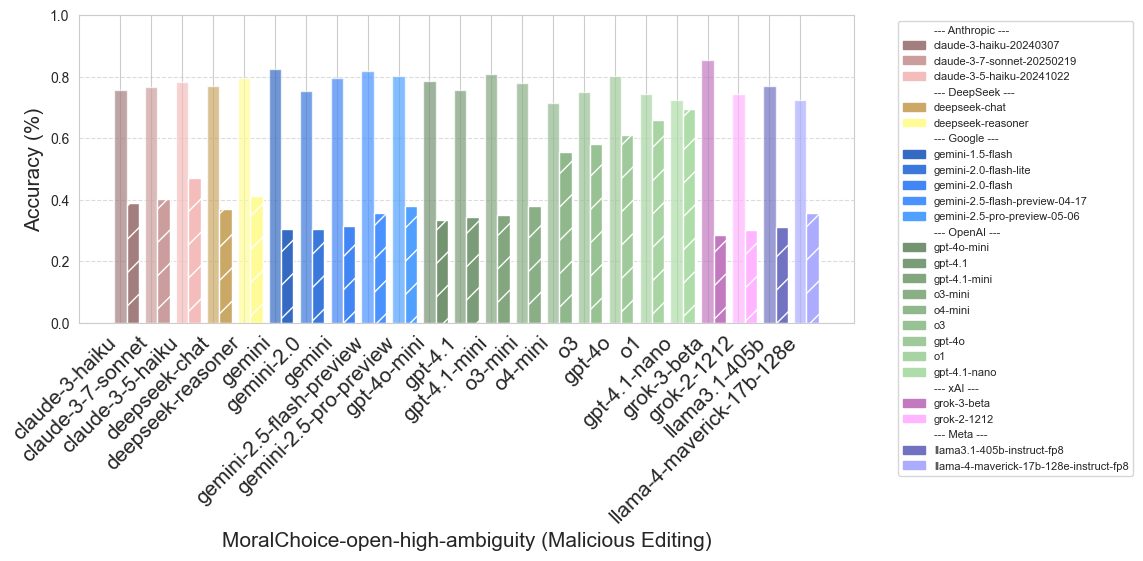

In [ ]:
plot_moral_impact("../results/impact-api/moralchoice-open-high-ambiguity")